In [39]:

from dotenv import load_dotenv
load_dotenv()

True

In [40]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

DB, tavily tool 정의

In [41]:

from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List

#embeddings_model = OllamaEmbeddings(model="qwen2.5:1.5b") 
embeddings_model = OllamaEmbeddings(model="bge-m3:latest")

# menu db 벡터 저장소 로드
menu_db = FAISS.load_local(
    "./db/menu_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
@tool
def search_menu(query: str) -> List[str]:
    """레스토랑 메뉴에서 정보를 검색합니다."""
    docs = menu_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

In [42]:

from langchain_community.tools import TavilySearchResults


# Tool 정의 
@tool
def search_web(query: str) -> List[str]:
    """데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다."""

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

2개 bind

In [43]:

from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
print(llm.model_name)

# 도구 목록
tools = [search_menu, search_web]
print(type(search_menu))

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)
print(type(llm_with_tools))

gpt-4o-mini
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.runnables.base.RunnableBinding'>


In [44]:

from langchain_core.messages import HumanMessage

# 도구 호출 ( Vector DB )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"스테이크"}',
                              'name': 'search_menu'},
                 'id': 'call_mUDvYuuevtA6r6IUXDlN6mBm',
                 'index': 0,
                 'type': 'function'}]}


In [45]:

# 도구 호출 ( Tavily )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"LangGraph는 무엇인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"LangGraph"}',
                              'name': 'search_web'},
                 'id': 'call_PbaNjgxBSRMmPfRBvpLSvtHn',
                 'index': 0,
                 'type': 'function'}]}


In [46]:

# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{}


In [47]:

pprint(tool_call)

AIMessage(content='3 + 3은 6입니다.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--c0e593a2-8574-46c9-abd8-6a40c0d39800-0')


### Tool Node
> bind_tools랑 비슷
- AI 모델이 요청한 도구(tool) 호출을 실행하는 역할을 처리하는 LangGraph 콤포넌트
- 작동 방식:
    - 가장 최근의 AIMessage에서 도구 호출 요청을 추출 (반드시, AIMessage는 반드시 tool_calls가 채워져 있어야 함)
    - 요청된 도구들을 병렬로 실행
    - 각 도구 호출에 대해 ToolMessage를 생성하여 반환

In [48]:

from langgraph.prebuilt import ToolNode

# 도구 노드 정의 
tools = [search_menu, search_web]
tool_node = ToolNode(tools=tools)

In [49]:

# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"스테이크"}',
                              'name': 'search_menu'},
                 'id': 'call_SvStcfLI0w50mEs1rEglDixO',
                 'index': 0,
                 'type': 'function'}]}


In [59]:

# 도구 호출 결과를 메시지로 추가하여 실행 
# 도구 호출 
#tool_call_result = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])
tool_call_result = llm_with_tools.invoke("시그니처 스테이크 메뉴의 가격은 얼마인가요?")
results = tool_node.invoke({"messages": [tool_call_result]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print('**** --------------------------- ****')

Error: AssertionError()
 Please fix your mistakes.
**** --------------------------- ****


In [51]:

# LLM 모델을 이용하여 도구를 호출하여 실행 
results = tool_node.invoke({"messages": [llm_with_tools.invoke("LangGraph는 무엇인가요?")]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print()

<Document href="https://www.ibm.com/think/topics/langgraph"/>
LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for building agent-based systems, which can be used in applications such as robotics, autonomous vehicles or video games.

LLM applications: By using LangGraph’s capabilities, developers can build more sophisticated AI models that learn and improve over time. Norwegian Cruise Line uses LangGraph to compile, construct and refine guest-facing AI solutions. This capability allows for improved and personalized guest exper

### ReAct Agent
ReAct(Reasoning and Acting) : 가장 일반적인 에이전트

동작 방식:

- 행동 (act): 모델이 특정 도구를 호출
- 관찰 (observe): 도구의 출력을 모델에 다시 전달
- 추론 (reason): 모델이 도구 출력을 바탕으로 다음 행동을 결정 (예: 또 다른 도구를 호출하거나 직접 응답을 생성)

create_react_agent() 쉽게 이해하기
1. 에이전트의 두뇌 역할
    - llm(언어모델)이 "생각"을 담당
    - 예시: "날씨 정보가 필요하니 날씨 API를 사용해야겠다"
2. 도구 사용 자동화
    - tools 리스트에 등록된 기능들을 필요시 자동 호출
    - 예시: 날씨 API 호출 → 결과 받아옴
3. 자체 점검 과정
    - 한 번에 해결되지 않으면 반복 실행
    - 예시:
        - 1차: "위치가 필요하니 위치 API 먼저 호출"
        - 2차: "받은 위치로 날씨 조회"
4. 최종 응답 생성
    - 모든 과정 종료 후 사용자에게 친절한 답변 구성
    - 예시: "오늘 서울은 맑고 25도입니다"




(1) 랭그래프 내장 ReAct 에이전트 사용

<class 'langgraph.graph.state.CompiledStateGraph'>


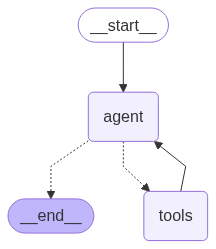

In [52]:

from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent  # 미리 정의된 에이전트 생성 함수

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm, 
    tools=tools, 
)

"""
[create_react_agent() 설명]
1. 역할: 
   - 'ReAct(Reasoning + Acting)' 프레임워크 기반의 자동화 에이전트 생성
   - 에이전트가 '생각(Reasoning)'과 '행동(Acting)'을 반복하며 문제 해결

2. 동작 방식:
   - 사용자 질문 → LLM이 '생각' → 필요한 도구 선택 → 도구 실행 → 결과 분석 → 최종 응답
   - 이 과정을 자동으로 반복하는 그래프 구조 생성

3. 예시 시나리오:
   "오늘 서울 날씨 알려줘" 질문 시:
   1. 날씨 API 도구 사용 필요 판단
   2. 날씨 API 호출
   3. 결과 해석 후 사용자 응답 생성
"""

print(type(graph)) # <class 'langgraph.graph.StateGraph'>

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

```python
state = {
    "messages": [
        HumanMessage(...),  # 입력
        AIMessage(...),     # 도구 사용 요청
        ToolMessage(...),   # 도구 실행 결과
        AIMessage(...)      # 최종 답변
    ]
}
다중 메시지 타입 지원
HumanMessage: 사용자 입력
AIMessage: AI의 응답/생각
ToolMessage: 도구 실행 결과
SystemMessage: 시스템 지시
# 이전 대화 포함 예제
inputs = {
    "messages": [
        HumanMessage("스테이크 추천해줘"),
        AIMessage("안심 스테이크가 인기 메뉴입니다"),
        HumanMessage("가격은 얼마인가요?")  # 이전 맥락 유지
    ]
}
```

In [53]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}

"""
[실행 과정]
1. inputs → 그래프 시작 노드로 전달
2. 각 노드에서 'messages' 리스트 업데이트
3. 최종 상태 반환 (모든 메시지 포함)
"""
messages = graph.invoke(inputs)

for m in messages['messages']:
    print(type(m), m)
    m.pretty_print()

<class 'langchain_core.messages.human.HumanMessage'> content='스테이크 메뉴의 가격은 얼마인가요?' additional_kwargs={} response_metadata={} id='96ccad81-9225-42b4-abbe-700fcca8f388'
================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_DBZ5FVsbfvIAZOojUcEd4rjJ', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'} id='run--fc236176-5e14-4a52-807d-cd78aaf2e7d9-0' tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_DBZ5FVsbfvIAZOojUcEd4rjJ', 'type': 'tool_call'}]
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_DBZ5FVsbfvIAZOojUcEd4rjJ)
 Call ID: call_DBZ5FVsbfvIA

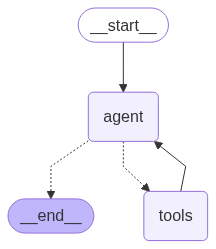

In [54]:

from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.messages import SystemMessage
from textwrap import dedent  # 들여쓰기 자동 조정

# 시스템 프롬프트
system_prompt = dedent("""
당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 스테이크  

(도구 실행 후)  
[출처: search_menu | 스테이크 | ./data/menu.txt]  
스테이크 정보: 양념 스테이크 35,000원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성
""")

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm,        # 언어 모델 (예: ChatOpenAI 인스턴스)
    tools=tools,   # 사용 가능한 도구 리스트
    #state_modifier=system_prompt,
    #system_message=SystemMessage(content=system_prompt),
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:

# 그래프 실행
messages = [
        SystemMessage(content=system_prompt),   # 시스템 프롬프트 설정 (AI의 행동 지침)
        HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")  # 사용자 질문
    ]
#inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
#messages = graph.invoke(inputs)

# 그래프 실행 (SystemMessage 포함)
messages = graph.invoke({"messages": messages})
"""
[실행 과정]
1. SystemMessage를 먼저 처리 → AI의 행동 규칙 설정
2. HumanMessage 처리 → 질문 분석 및 도구 사용 결정
3. 필요한 경우 tools 리스트의 도구들 자동 호출
4. 최종 응답 생성
"""

for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 스테이크  

(도구 실행 후)  
[출처: search_menu | 스테이크 | ./data/menu.txt]  
스테이크 정보: 양념 스테이크 35,000원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  sear

(2) 조건부 엣지 함수를 사용자 정의

- should_continue 함수에서 도구 호출 여부에 따라 종료 여부를 결정
- 도구 실행이 필요한 경우에는 그래프가 종료되지 않고 계속 실행

<class 'langgraph.graph.state.CompiledStateGraph'>


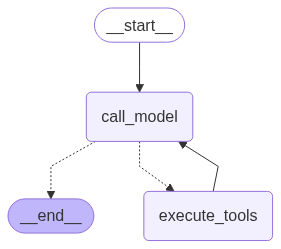

In [56]:

from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()
print(type(graph))

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_Ee4GlgHBdBvKdIEku8bcbXsH)
 Call ID: call_Ee4GlgHBdBvKdIEku8bcbXsH
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

Error: AssertionError()
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  search_web (call_BXe11Jtrs3bX0BxpOLeceQaF)
 Call ID: call_BXe11Jtrs3bX0BxpOLeceQaF
  Args:
    query: 스테이크 메뉴 가격
================================= Tool Message =================================
Name: search_web

<Document href="https://m.blog.naver.com/pooky34/221348019580"/>
저는 어두컴컴한 조명과 다소 촌스러워 보일 수 있는 비닐 소파가 나쁘지 않았으나, 분명한 것은 현대적인 감각과는 거리가 있다는 점이었어요. 그렇기 때문에 젊은 사람들 사이에서는 호불호가 갈릴것 같았는데, 저는 미국에서 전통있는 스테이크 하우스를 다녀와 보는 것도 나쁘지 않을 것 같았답니다.

Image 9



(3) tools_condition 활용

- LangGraph에서 제공하는 도구 사용을 위한 조건부 엣지 함수
- 최신 메시지(결과)가 도구 호출이면 -> tools_condition이 도구로 라우팅
- 최신 메시지(결과)가 도구 호출이 아니면 -> tools_condition이 END로 라우팅

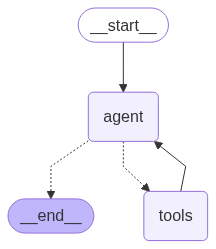

In [61]:

from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:

# 그래프 실행
inputs = {"messages": [HumanMessage(content="해산물 파스타의 가격은 얼마인가요? 해산물 파스타에 어울리는 음료는 무엇인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

해산물 파스타의 가격은 얼마인가요? 해산물 파스타에 어울리는 음료는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_7aQ4RjM07sjA0IHrPHegUCln)
 Call ID: call_7aQ4RjM07sjA0IHrPHegUCln
  Args:
    query: 해산물 파스타
  search_menu (call_SHmTIyPgLf091SpyLWrq2oWz)
 Call ID: call_SHmTIyPgLf091SpyLWrq2oWz
  Args:
    query: 해산물
================================= Tool Message =================================
Name: search_menu

Error: AssertionError()
 Please fix your mistakes.
================================= Tool Message =================================
Name: search_menu

Error: AssertionError()
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_nrn345FUgv8yswTcpQs2Y8Hy)
 Call ID: call_nrn345FUgv8yswTcpQs2Y8Hy
  Args:
    query: 해산물 파스타
================================= Tool Message ===